## OASIS Dataset Analysis (II)

Link to the original paper
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2895005/

Aim of this post: use linear mixed-effects models to look at the fixed and random effects in this dataset. 

## Linear mixed-effects models (LME)

Linear mixed effects models are based on the simple linear regression model that allow for the measure of both fixed and random effects. Definitions of random and fixed effects are not necessarily to do with the variables themselves but vary depending on the research question. Fixed effects are the effects of variables of interest. In this blog for example one of the variables of interest is the MMSE score so we want to look at its effect on the likelihood of the subject developing dementia. Whereas random effects are usually any variation are a result of regions that are not of interest to us. For example variability between subjects can be seen as a random effect. These models are used for when there is non-independence in the data and are also good for designs with repeated measures as well as data with missing values. Whereas with an ANOVA test, independence of variables and a normally distributed sample is assumed. 

## Loading and Preprocessing 

In [1]:
import pandas as pd

In [2]:
oasis_df = pd.read_csv('oasis_longitudinal.csv')

oasis_df = oasis_df.drop(['MRI ID','MR Delay', 'Hand'], axis=1)
oasis_df = oasis_df.rename({'Subject ID': 'Subject_ID', "M/F" : 'Gender'}, axis=1)
oasis_df['Gender'] = oasis_df['Gender'].astype('category')
oasis_df['Gender'] = oasis_df['Gender'].cat.codes

oasis_df

,Subject_ID,Group,Visit,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,Nondemented,1,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,Nondemented,2,1,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,Demented,1,1,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,Demented,2,1,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,Demented,3,1,80,12,NaN,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,Demented,2,1,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,Demented,3,1,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,Nondemented,1,0,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,Nondemented,2,0,63,13,2.0,30.0,0.0,1327,0.796,1.323


The dummy coding is done here for the 'Group' column as these are categorical. Also we want to remove the participants who already have dementia as we want to see what potentially affects whether someone develops dementia.

In [3]:
one_visit = oasis_df[oasis_df['Visit'] == 1] # subset of data 
dummies = pd.get_dummies(one_visit["Group"]) # dummy coding for group
one_visit = one_visit.merge(dummies, left_index=True, right_index=True).dropna()
one_visit = one_visit[ one_visit["Demented"] != 1 ] # removed participants who already have dementia
one_visit.head()

,Subject_ID,Group,Visit,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Converted,Demented,Nondemented
0,OAS2_0001,Nondemented,1,1,87,14,2.0,27.0,0.0,1987,0.696,0.883,0,0,1
5,OAS2_0004,Nondemented,1,0,88,18,3.0,28.0,0.0,1215,0.710,1.444,0,0,1
7,OAS2_0005,Nondemented,1,1,80,12,4.0,28.0,0.0,1689,0.712,1.039,0,0,1
13,OAS2_0008,Nondemented,1,0,93,14,2.0,30.0,0.0,1272,0.698,1.380,0,0,1
19,OAS2_0012,Nondemented,1,0,78,16,2.0,29.0,0.0,1333,0.748,1.316,0,0,1


### Questions

1. Which factors most affect whether a participant develops dementia?
2. Which factors affect participants' scores from baseline compared to their second visit? 

For this post, linear mixed effects models are used instead.

In [4]:
both_visits = oasis_df[oasis_df['Visit'] <= 2].dropna()

both_visits = both_visits.groupby('Subject_ID').filter(lambda x: len(x) == 2)
both_visits_EDUC_SES_gender = both_visits[['Subject_ID','EDUC','SES','Gender']] #keep values that do not change
both_visits = both_visits.sort_values(["Subject_ID", "Visit"])
both_visits_diff = both_visits.groupby(['Subject_ID'])[['Age', 'MMSE',
                                                        'CDR', 'eTIV', 'nWBV', 'ASF']].diff().dropna()
both_visits = both_visits[["Subject_ID", "Group"]].merge(both_visits_diff, left_index=True, right_index=True)
both_visits = both_visits.merge(both_visits_EDUC_SES_gender, left_index=True, right_index=True, suffixes=(None,'_y'))
both_visits = both_visits.drop(columns = ['Subject_ID_y'])

dummies = pd.get_dummies(both_visits["Group"])
both_visits = both_visits.merge(dummies, left_index=True, right_index=True).dropna()

both_visits = both_visits[both_visits["Demented"] != 1]
both_visits = both_visits.drop(columns='Group')

# Preliminary Tests

In [5]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pylab as py
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
both_visits.head()

,Subject_ID,Age,MMSE,CDR,eTIV,nWBV,ASF,EDUC,SES,Gender,Converted,Demented,Nondemented
1,OAS2_0001,1.0,3.0,0.0,17.0,-0.015,-0.007,14,2.0,1,0,0,1
6,OAS2_0004,2.0,-1.0,0.0,-15.0,0.008,0.018,18,3.0,0,0,0,1
8,OAS2_0005,3.0,1.0,0.5,12.0,-0.001,-0.007,12,4.0,1,0,0,1
14,OAS2_0008,2.0,-1.0,0.0,-15.0,0.005,0.016,14,2.0,0,0,0,1
20,OAS2_0012,2.0,0.0,0.0,-10.0,-0.010,0.010,16,2.0,0,0,0,1


In [7]:
model_fit = smf.ols('Converted ~ Age+EDUC+SES+MMSE+eTIV+nWBV+ASF+Gender', data=both_visits).fit()

X = pd.DataFrame(both_visits, columns=['Age','EDUC','SES', 'MMSE','eTIV','nWBV','ASF', 'Gender'])
y = pd.DataFrame(both_visits.Converted)
dataframe = pd.concat([X, y], axis=1)

table = sm.stats.anova_lm(model_fit, typ=2)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    display(table.sort_values("F", ascending=False))

,sum_sq,df,F,PR(>F)
MMSE,1.274274,1.0,12.471175,0.000720
SES,0.962042,1.0,9.415391,0.003019
Age,0.602529,1.0,5.896878,0.017632
EDUC,0.545404,1.0,5.337811,0.023696
Gender,0.136944,1.0,1.340251,0.250764
ASF,0.035178,1.0,0.344279,0.559180
eTIV,0.033727,1.0,0.330083,0.567377
nWBV,0.000235,1.0,0.002301,0.961871
Residual,7.458961,73.0,NaN,NaN


In [8]:
#model values 
model_fitted_y = model_fit.fittedvalues
model_residuals = model_fit.resid
model_norm_residuals = model_fit.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
model_abs_resid = np.abs(model_residuals)
model_leverage = model_fit.get_influence().hat_matrix_diag
model_cooks = model_fit.get_influence().cooks_distance[0]

## Q-Q plot 

In order to check whether the data used is normally distributed, we can use a quantile-quantile plot. It is a probability plot comparing two probability distributions where the x coordinate is a theoretical quantile and the y-coordinate is the quantile from the actual data. If the distribution is normal then the points will roughly lie on the line *y = x*.

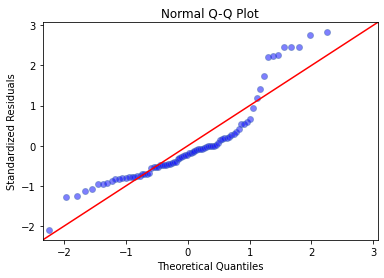

In [9]:
from statsmodels.graphics.gofplots import ProbPlot

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q Plot')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

The Q-Q plot shows that there are many outliers that do not fit well on the line indication a deviation from a normal distribution. This makes it evident that another type of statistical model might be better for this dataset. 

## Shapiro-Wilk Test
Another more robust test for normality is the Shapiro-Wilk Test (Shapiro & Wilk, 1965) and this was applied to the measures from the data below. For this test the null hypothesis if that the observations are normally distributed.

In [10]:
from scipy.stats import shapiro
from tabulate import tabulate

In [11]:
shapiro_results = []

for column in both_visits:
    try:
        s = shapiro(both_visits[column])
        shapiro_results.append([column, s.statistic, s.pvalue])
    except Exception as e:
        pass

df = pd.DataFrame(shapiro_results)
df = df.drop([9,10,11], axis=0) #drop dummy measures
print('Shapiro-Wilk Test \n')
print(tabulate(df, headers=['Measure', 'W statistic', 'p value'],showindex="never",tablefmt="presto"))  

Shapiro-Wilk Test 

 Measure   |   W statistic |     p value
-----------+---------------+-------------
 Age       |      0.84819  | 1.06861e-07
 MMSE      |      0.857197 | 2.17703e-07
 CDR       |      0.431455 | 3.12775e-16
 eTIV      |      0.859982 | 2.72737e-07
 nWBV      |      0.987887 | 0.640755
 ASF       |      0.878246 | 1.28239e-06
 EDUC      |      0.933238 | 0.000356511
 SES       |      0.876038 | 1.05635e-06
 Gender    |      0.578552 | 5.53986e-14


/usr/local/lib/python3.8/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


The only variable that seems to be normally distributed here is the nWBV with W = 0.99 and p value = .64, indicating normality. This is expected as these values have already been normalised as mentioned in the paper. 

## Linear Mixed Effects Models

In this first model, using the statsmodel function *mixedlm()*, five of the variables are treated as fixed effects with subject as the random effect as defined in the argument *groups*. This would be the equivalent of \begin{equation*} Converted \backsim MMSE... + (1 | Subject)\end{equation*} in R. All of the effects are calculated here in terms of interactions and simple effects. By default and because I have not specified it there is a random intercept for each group. The Bayesian Information Criteria (BIC) is pulled here as well to have a criteria for model fitting: the higher the score, the better. However it should be noted that every time a variable is added this score will increase. 

In [12]:
#fit model
mixed = smf.mixedlm('Converted ~ MMSE*nWBV*eTIV*EDUC*SES',data=both_visits, groups=both_visits['Subject_ID'])
mixed_fit = mixed.fit(reml=False)

/usr/local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2189: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [13]:
#print summary
mixed_fit_results = mixed_fit.summary()
print(mixed_fit_results)
BIC_1 = mixed_fit.bic
print('Bayesian Information Criteria (BIC): ', BIC_1) 

                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Converted
No. Observations:      82           Method:                  ML       
No. Groups:            82           Scale:                   0.0307   
Min. group size:       1            Log-Likelihood:          -1.9069  
Max. group size:       1            Converged:               Yes      
Mean group size:       1.0                                            
----------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------
Intercept                 0.094    0.715  0.131 0.896   -1.308   1.496
MMSE                     -0.904    0.732 -1.234 0.217   -2.338   0.531
nWBV                    -21.038   77.849 -0.270 0.787 -173.618 131.543
MMSE:nWBV               -43.271   60.534 -0.715 0.475 -161.916  75.374
eTIV                   

In [14]:
#convert summary results to dataframe
def summary_to_df(results):
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0] #lower confidence interval of the fitted parameters
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [15]:
summary_df = summary_to_df(mixed_fit)
sig_pvals = summary_df[summary_df ['pvals']<= 0.05]
sig_pvals

,coeff,pvals,conf_lower,conf_higher
MMSE:eTIV,0.251948,0.000726,0.105827,0.398068
MMSE:nWBV:eTIV,17.493033,0.000548,7.572879,27.413187
MMSE:eTIV:EDUC,-0.016371,0.000809,-0.025949,-0.006792
MMSE:nWBV:eTIV:EDUC,-1.143294,0.000492,-1.786245,-0.500342
MMSE:eTIV:SES,-0.102714,0.000348,-0.158998,-0.046431
MMSE:nWBV:eTIV:SES,-7.348724,0.000059,-10.936178,-3.761270
MMSE:eTIV:EDUC:SES,0.006792,0.000834,0.002808,0.010776
MMSE:nWBV:eTIV:EDUC:SES,0.493338,0.000256,0.228863,0.757812


We can see the significant effects of the interactions here. It seems that the combinations of these variables is an important measure for the question.

In [16]:
#fit model 2 
mixed2 = smf.mixedlm('Converted ~ MMSE+SES+EDUC+nWBV+eTIV+Age+Gender',data=both_visits, groups=both_visits['Subject_ID'])
mixed2_fit = mixed2.fit(reml=False)

print(mixed2_fit.summary())
print('Bayesian Information Criteria (BIC): ', mixed2_fit.bic) 

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Converted
No. Observations: 82      Method:             ML       
No. Groups:       82      Scale:              0.0457   
Min. group size:  1       Log-Likelihood:     -18.2564 
Max. group size:  1       Converged:          Yes      
Mean group size:  1.0                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.849    0.199  4.274 0.000  0.460  1.239
MMSE         -0.098    0.026 -3.792 0.000 -0.149 -0.048
SES          -0.144    0.029 -4.997 0.000 -0.200 -0.087
EDUC         -0.043    0.009 -4.695 0.000 -0.061 -0.025
nWBV         -0.553    4.346 -0.127 0.899 -9.071  7.966
eTIV         -0.000    0.002 -0.021 0.983 -0.003  0.003
Age           0.109    0.041  2.636 0.008  0.028  0.189
Gender        0.089    0.074  1.205 0.228 -0.056  0.233
G

/usr/local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2189: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


The second LME model only measures the simple effects of the fixed effects. The BIC is a lot smaller as there are fewer observations. 

In [17]:
summary_df2 = summary_to_df(mixed2_fit)
sig_pvals2 = summary_df2[summary_df2['pvals'] <= 0.05]
sig_pvals2

,coeff,pvals,conf_lower,conf_higher
Intercept,0.849244,1.921953e-05,0.459778,1.238711
MMSE,-0.098328,1.494001e-04,-0.149149,-0.047506
SES,-0.143899,5.828538e-07,-0.200342,-0.087456
EDUC,-0.042990,2.666300e-06,-0.060937,-0.025043
Age,0.108547,8.391635e-03,0.027835,0.189259


The estimated p values show that the four variables that seem to have the most effect on the Converted variable is: MMSE, SES, EDUC and Age. Age is perhaps a variable that should not be included in the model as dementia is an age-related disorder we would expect that as age increases so does the risk of dementia. However it is interesting to see SES, MMSE and EDUC which are most likely connected especially in certain countries with starker disparities in wealth. Let's go back to the original dataset and look at these potential relationships. I have used a subset of the dataset named *one_visit* which contains only the first visit i.e. the baseline values because all of the participants had at least one visit. Also the effect of time on the scores especially for MMSE will change and there will be multiple scores for one participant. 

R-Squared: 0.47


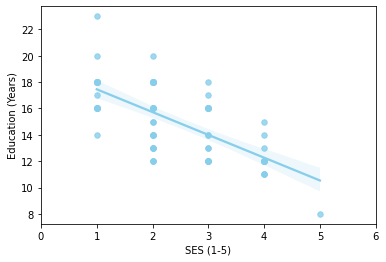

In [18]:
oasis_df2 = oasis_df.dropna() #remove missing scores

g = sns.regplot(x='SES',y='EDUC', data=one_visit,color="skyblue", scatter_kws={'s':30}, label = 'A');
g = g.set(xlim=(0,6), xlabel="SES (1-5)", ylabel="Education (Years)")


correlation_matrix = np.corrcoef(one_visit['SES'], one_visit['EDUC'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2


print("R-Squared:","{:.2f}".format(r_squared))


R-Squared: 0.0002


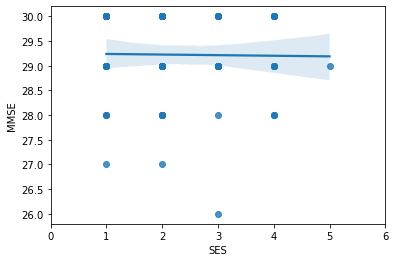

In [19]:
g2 = sns.regplot(x='SES',y='MMSE', data=one_visit);
g2 = g2.set(xlim=(0, 6))

correlation_matrix = np.corrcoef(one_visit['SES'], one_visit['MMSE'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print("R-Squared:","{:.4f}".format(r_squared))

R-Squared: 0.01


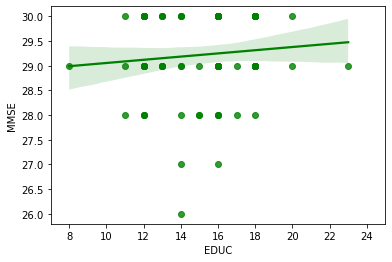

In [20]:
g3 = sns.regplot(x='EDUC',y='MMSE', data=one_visit, color="g");
g3 = g3.set(xlim=(7, 25))

oasis_df2 = one_visit.dropna()
correlation_matrix = np.corrcoef(one_visit['EDUC'], one_visit['MMSE'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print("R-Squared:","{:.2f}".format(r_squared))

Running the simple linear regression models comparing two of the variables at a time, it is evident that in this dataset EDUC, MMSE & SES do not correlate that well with R-squared values of 0.47, 0.0002 & 0.01. Although Education and SES seem to show a pattern in the graph it is not a strong enough correlation to assume a connection between the two.

LME models are common practice in longitudinal studies and did give more insight into the data compared to the ANOVA which is probably not the best method to use for this dataset due to missing data and non-independence of variables. In addition, the models that I used may not be the best for this dataset either and can be interpreted in other ways for example some might suggest that socioeconomic status could be treated as a random effect depending on how the sample was collected. Another aspect I did not delve into is possible nested effects. 

### References

Shapiro, S. S., & Wilk, M. B. (1965). An analysis of variance test for normality (complete samples). Biometrika, 52(3/4), 591-611.
